# Sentinel Hub Batch Statistical

Requesting statistical data (as shown in [Statistical API tutorial](./statistical_request.ipynb)) instead of entire images already reduces the amount of data we need to download and process. To make large-scale requests even more time and cost efficient one can use the Batch Statistical API, the statistical counterpart of the [Batch Processing API](./batch_processing.ipynb). By using server-side parallelization it delivers results faster and more cost efficiently directly to your S3 bucket.

More information about batch processing is available at Sentinel Hub documentation pages:

- [How Batch Statistical API works](https://docs.sentinel-hub.com/api/latest/api/batch-statistical/)
- [Batch Statistical API service description](https://docs.sentinel-hub.com/api/latest/reference/#tag/batch_statistical)

### Overview

The tutorial will show a small example of using the Batch Statistical API with `sentinelhub-py`. The process can largely be divided into:

1. Preparing credentials and storage
2. Define and create a batch request
3. Analyse, start and monitor the execution of the request
4. Check results


### Imports

The tutorial requires additional packages `geopandas` and `matplotlib` that are not dependencies of `sentinelhub-py`.

In [1]:
%matplotlib inline

import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from sentinelhub import (
    DataCollection,
    SentinelHubBatchStatistical,
    SentinelHubStatistical,
    SHConfig,
    monitor_batch_statistical_job,
    parse_time,
)
from sentinelhub.aws.batch import AwsBatchResults

## 1. Credentials and Storage


### 1.1 Sentinel Hub credentials
Credentials for Sentinel Hub should be set in the same way as for regular statistical requests. Please check [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) about how to set up your Sentinel Hub credentials.

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Batch Statistical API, please provide the credentials (OAuth client ID and client secret).")

### 1.2 AWS credentials

Batch Statistical API uses S3 buckets for both *input* and *output*. It can be the same bucket for both, or a two completely separate buckets. Whichever it might be, the Batch Statistical Request needs permissions for reading and writing to buckets.

Due to security reasons we **strongly advise you to not provide your master credentials**. Using a temporary IAM user, which is deleted after the batch request, is a much safer alternative. [Here](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_users_create.html#id_users_create_console) is the official guide on how to approach this. You need to provide the `AWS Access ID` and `AWS Secret Key` of the selected IAM user to the Batch Statistical Request.

To further improve security we also encourage you to assign a strict policy to the IAM role. The permissions it needs are `GetObject`, `PutObject` and `DeleteObject`, so the policy should look something like this:

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:PutObject",
                "s3:GetObject",
                "s3:DeleteObject"
            ],
            "Resource": [
                "arn:aws:s3:::<my-bucket>/<optional-path-to-relevant-subfolder>/*"
            ]
        }
    ]
}
```


In [3]:
AWS_ID = "my-aws-access-id"
AWS_SECRET = "my-aws-secret-key"

### 1.3 Preparing input

The geometries for which the Batch Statistical Request is evaluated are provided as input via a GeoPackage file on an S3 bucket. All features (polygons) in the input GeoPackage must be in the same CRS (which has to be [supported by Sentinel Hub](https://docs.sentinel-hub.com/api/latest/api/process/crs/)).

A custom column `identifier` of type `string` can be added to GeoPackage and its value will be available in an output file as `identifier` property.

For this example notebook we'll be using the Sentinel Hub [example geopackage](https://docs.sentinel-hub.com/api/latest/32c456e0ade0dba65dd229821d5a508b/geopackage-example.gpkg).

Lets first take a quick glance at the example file.

In [4]:
# The following lines assume that the example geopackage is downloaded to the same folder as the notebook
example_input = gpd.read_file("geopackage-example.gpkg")
example_input

,identifier,geometry
0,SI21.FOI.7059004001,"MULTIPOLYGON (((16.03718 46.42175, 16.03721 46..."
1,SI21.FOI.7059009001,"MULTIPOLYGON (((16.04074 46.41680, 16.04081 46..."
2,SI21.FOI.6620269001,"MULTIPOLYGON (((16.04012 46.41566, 16.04004 46..."
3,SI21.FOI.6681475001,"MULTIPOLYGON (((16.04098 46.41634, 16.04069 46..."
4,SI21.FOI.6828863001,"MULTIPOLYGON (((16.03891 46.41792, 16.03891 46..."
...,...,...
359,SI21.FOI.6741898001,"MULTIPOLYGON (((16.00068 46.41867, 16.00064 46..."
360,SI21.FOI.6741894001,"MULTIPOLYGON (((15.99822 46.42195, 15.99822 46..."
361,SI21.FOI.6511522001,"MULTIPOLYGON (((16.00348 46.41886, 16.00324 46..."
362,SI21.FOI.6282186001,"MULTIPOLYGON (((16.01307 46.42134, 16.01308 46..."


We see that the example file also has custom identifiers set. We should also visualize the polygons to check everything is sensible. The geometries represent fields in north-eastern Slovenia.

<AxesSubplot:>

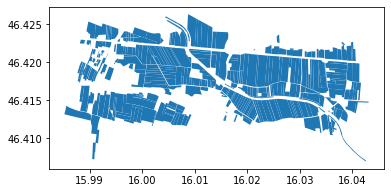

In [6]:
example_input.plot()

However it's CRS is WGS84. We'd prefer to work in a CRS that uses meters as units, so let's reproject everything to the UTM zone 33N (EPSG: 32633).

In [29]:
example_input.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
reprojected_geometries = example_input.to_crs("epsg:32633")
reprojected_geometries.crs

<Derived Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°E and 18°E, northern hemisphere between equator and 84°N, onshore and offshore. Austria. Bosnia and Herzegovina. Cameroon. Central African Republic. Chad. Congo. Croatia. Czechia. Democratic Republic of the Congo (Zaire). Gabon. Germany. Hungary. Italy. Libya. Malta. Niger. Nigeria. Norway. Poland. San Marino. Slovakia. Slovenia. Svalbard. Sweden. Vatican City State.
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
reprojected_geometries[:100].to_file("reprojected-geoms.gpkg")

We must now transfer the `"reprojected-geoms.gpkg"` file to the designated S3 bucket. It should be placed in such a way that the IAM user we'll be using has access to it.

Each job output will be saved in a folder named after the request ID, but to keep things organized we'll also use the `output` subfolder. 

In [38]:
INPUT_PATH = "s3://<my-bucket>/<path-to-relevant-subfolder>/reprojected-geoms.gpkg"
OUTPUT_PATH = "s3://<my-bucket>/<path-to-relevant-subfolder>/output/"

## 2. Make a Batch Statistical API request

Batch statistical requests are largely the same as regular statistical requests. In fact we'll use a slightly modified version of the request in the [Statistical API tutorial](./statistical_request.ipynb).

### 2.1 Defining the request

Since both request types are so similar we are able to make use of `SentinelHubStatistical` helper methods. Let us define the statistical part of the request first. We're interested in the NDVI values of the fields in June of 2020.

In [39]:
rgb_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B04",
          "B08",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(samples) {
    return {
      ndvi: [index(samples.B08, samples.B04)],
      dataMask: [samples.dataMask]
    };
}
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=rgb_evalscript,
    time_interval=("2020-06-01", "2020-06-30"),
    aggregation_interval="P1D",
    resolution=(10, 10),
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

input_data = [SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L1C, maxcc=0.8)]

Now we define the storage specifications. For this we can use helpe method `SentinelHubBatchStatistical.s3_specification` that generates a dictionary specifying an S3 access. One can also write all of the dictionaries by hand, as long as they follow the [official specifications](https://docs.sentinel-hub.com/api/latest/reference/#operation/createNewBatchStatisticsRequest).

In [43]:
input_features = SentinelHubBatchStatistical.s3_specification(INPUT_PATH, AWS_ID, AWS_SECRET)
output = SentinelHubBatchStatistical.s3_specification(OUTPUT_PATH, AWS_ID, AWS_SECRET)

### 2.2 Creating the request

We first create a Batch Statistical client with which we'll manage any requests.

In [44]:
client = SentinelHubBatchStatistical()

We then create a new request with the `create` method. If we have any `SentinelHubStatistical` requests on hand, we can use them to create an *upgraded* batch request via the `create_from_request` method. The geometry of the original request is then substituted with the input file.

In [45]:
# Note: all arguments must be passed as keyword arguments
request = client.create(
    input_features=input_features,
    input_data=input_data,
    aggregation=aggregation,
    calculations=histogram_calculations,
    output=output,
)

request

BatchStatisticalRequest(
  request_id=6cd43a45-631f-4d11-90df-4a832d6430b0
  created=2022-08-11 07:30:45.985911+00:00
  status=BatchRequestStatus.CREATED
  user_action=BatchUserAction.NONE
  cost_pu=0.0
  completion_percentage=0
  ...
)

The `request_id` field is especially important, since most of the client methods only require the ID to work. It can also be used to continue with the same job in a different notebook or after resetting the environment.

The `BatchStatisticalRequest` class contains more than just what is listed above. You always have the option of using the `to_dict` and `from_dict` methods if you wish to see the entire content at once or need to iterate over all the values.

## 3. Analyse, start and monitor the request

Analysis of a request is automatically done prior to starting the job. You can also trigger it manually with the `start_analysis` method. While the analysis cannot infer the cost of the request (too many things to take into consideration) it does some preparations for the job and verifies the input file.

We'll just go ahead and start the request.

In [47]:
client.start_job(request)

''

If you wish to check on the current status of your request you can use the `get_status` method.

In [48]:
client.get_status(request)

{'id': '6cd43a45-631f-4d11-90df-4a832d6430b0',
 'status': 'CREATED',
 'completionPercentage': 0,
 'costPU': 0.0,
 'created': '2022-08-11T07:30:45.985911Z'}

We also have a utility function `monitor_batch_statistical_job` (and the analysis counterpart `monitor_batch_statistical_analysis`) that periodically checks the status and updates a progress bar.

In [49]:
# To get the full output we must configure the logger first
logging.basicConfig(level=logging.INFO)

monitor_batch_statistical_job(request, config=config, analysis_sleep_time=60)

INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status CREATED, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status ANALYSING, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job has a status ANALYSING, sleeping for 60 seconds
INFO:sentinelhub.api.batch.utils:Batch job is running
Completion percentage: 100%|██████████| 100/100 [05:31<00:00,  3.32s/it]


{'id': '6cd43a45-631f-4d11-90df-4a832d6430b0',
 'status': 'DONE',
 'completionPercentage': 100,
 'lastUpdated': '2022-08-11T07:42:07.184984Z',
 'costPU': 6.027410152775339,
 'created': '2022-08-11T07:30:45.985911Z'}

## 4. Check results

With the batch statistical request completed we do a quick inspection of the results. A folder with the same name as our request is located at `OUTPUT_PATH` and it contains multiple JSON files with results. The JSON files are named after the id of the row, not after our custom `identifier`, so we have files from `1.json` all the way to `100.json` on our bucket. 

We can transfer them to the local storage with the help of `AwsBatchResults`.

In [3]:
LOCAL_FOLDER = "batch_output"

# credentials are passed via config
config = SHConfig()
config.aws_access_key_id = AWS_ID
config.aws_secret_access_key = AWS_SECRET

batch_results_request = AwsBatchResults(request, data_folder=LOCAL_FOLDER, config=config)
results = batch_results_request.get_data(save_data=True, max_threads=4, show_progress=True)

100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


To transform the results into a Pandas dataframe we'll borrow the helper function from the Statistical API example notebook.

In [58]:
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

In [64]:
dfs = []
for result in results:
    result_df = stats_to_df(result["response"])
    result_df["identifier"] = result["identifier"]
    dfs.append(result_df)
df = pd.concat(dfs)
df

,interval_from,interval_to,ndvi_B0_min,ndvi_B0_max,ndvi_B0_mean,ndvi_B0_stDev,ndvi_B0_sampleCount,ndvi_B0_noDataCount,identifier
0,2020-06-01,2020-06-02,-0.019211,0.366078,0.167395,0.092565,112,3,SI21.FOI.7059004001
1,2020-06-04,2020-06-05,0.296662,0.435169,0.343738,0.034777,112,3,SI21.FOI.7059004001
2,2020-06-06,2020-06-07,0.246869,0.710537,0.376068,0.118973,112,3,SI21.FOI.7059004001
3,2020-06-11,2020-06-12,0.231761,0.693998,0.359988,0.095531,112,3,SI21.FOI.7059004001
4,2020-06-14,2020-06-15,0.287994,0.624406,0.398957,0.063102,112,3,SI21.FOI.7059004001
...,...,...,...,...,...,...,...,...,...
4,2020-06-14,2020-06-15,0.397197,0.470835,0.440288,0.026828,4,0,SI21.FOI.6828893001
5,2020-06-19,2020-06-20,0.438798,0.676927,0.554867,0.091883,4,0,SI21.FOI.6828893001
6,2020-06-24,2020-06-25,0.437500,0.644036,0.555784,0.075110,4,0,SI21.FOI.6828893001
7,2020-06-26,2020-06-27,0.214632,0.230008,0.224176,0.005748,4,0,SI21.FOI.6828893001


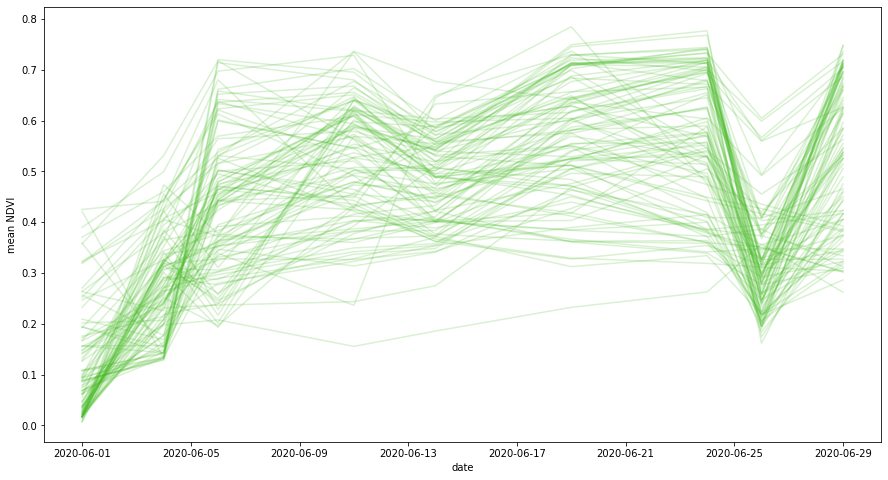

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))

for identifier, group in df.groupby("identifier"):
    group.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color="#44BB22", alpha=0.2)

ax.get_legend().remove()
plt.ylabel("mean NDVI")
plt.xlabel("date");